In [1]:
from data_augmentator import Data_Augmentator
from BKG_Dataholder import BKG_dataholder
from Coll_Data_Aug import Coll_Data_Augmentator
from collimator_utils import*


from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr


import torch
import torch.nn as nn
from torch.nn.functional import softmax,relu
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
import os
import json
import time,datetime
import tables as t
from tqdm import tqdm

%matplotlib inline


In [2]:
BEAM_PATH = "/home/mirksonius/Desktop/Fill_info/beam/"
COLLIMATOR_PATH = "/home/mirksonius/Desktop/Fill_info/collimators/"
VACUUM_PATH = "/home/mirksonius/Desktop/Fill_info/vacuum/"
FILL_PATH = "/home/mirksonius/Desktop/22_fills/"
FILL_NUMBER = 7886

vac_vars = [
    "VGI.183.1L5.X.PR",
    "VGI.183.1R5.X.PR",
    "VGI.220.1L5.X.PR",
    "VGI.220.1R5.X.PR"]

coll_vars = [
            ":SET_LD",
            #":SET_LU",
            #":SET_RD",
            #":SET_RU"
            ]


sheet_names = ["2022-06-21","2022-06-29","2022-06-30","2022-07-01","2022-07-03"]

In [3]:
bkg = BKG_dataholder(fill_path = FILL_PATH,
                                    fill_number = FILL_NUMBER,
                                    beam_path = BEAM_PATH,
                                   collimator_path = COLLIMATOR_PATH,
                                   vacuum_path= VACUUM_PATH  
                                 )
                                 
bkg.get_beam_data()
bkg.get_fill_data()
bkg.vacuum_variables = vac_vars
bkg.get_vacuum_data()
bkg.collimator_variables = coll_vars
bkg.get_collimator_data()



Opening file 7886_354586_2206290257_2206290257.hd5
File 7886_354586_2206290257_2206290257.hd5 starts at 2022-06-29 02:59:11 and ends at 2022-06-29 03:02:00
Opening file 7886_354587_2206290257_2206290345.hd5
File 7886_354587_2206290257_2206290345.hd5 starts at 2022-06-29 03:02:01 and ends at 2022-06-29 03:47:08
Opening file 7886_354588_2206290345_2206290558.hd5
File 7886_354588_2206290345_2206290558.hd5 starts at 2022-06-29 03:47:09 and ends at 2022-06-29 06:00:15
Opening file 7886_354591_2206290558_2206290652.hd5
File 7886_354591_2206290558_2206290652.hd5 starts at 2022-06-29 06:42:04 and ends at 2022-06-29 06:53:21
Opening file 7886_354592_2206290652_2206290704.hd5
File 7886_354592_2206290652_2206290704.hd5 starts at 2022-06-29 07:01:38 and ends at 2022-06-29 07:04:26
Opening file 7886_354593_2206290704_2206290704.hd5
File 7886_354593_2206290704_2206290704.hd5 starts at 2022-06-29 07:04:27 and ends at 2022-06-29 07:06:37
Opening file 7886_354594_2206290704_2206290743.hd5
File 7886_354

In [4]:
aug = Data_Augmentator(
    bkg_dh = bkg,
    vac_vars = vac_vars
    )
aug.loss_variables

Background points removed: 0
Precetnage removed: 0.0%
Luminosity points removed: 0
Precetnage removed: 0.0%


['TCTPH_B1',
 'TCTPH_B2',
 'TCL4_B2',
 'TCL4_B1',
 'TCTPV_B1',
 'TCTPV_B2',
 'TCL5_B1',
 'TCL5_B2',
 'TCL6_B2',
 'TCL6_B1']

In [5]:
collimator_columns = []
for c in aug.collimators:
    for var in aug.collimator_variables:
        collimator_columns.append(c+var)


tensor(0.9998)
tensor(0.8246)
tensor(0.8696)
tensor(0.9770)
tensor(0.7670)
tensor(0.9440)
tensor(0.9888)
tensor(0.9946)


Text(0.5, 1.0, 'Beam 2 background and collimator losses')

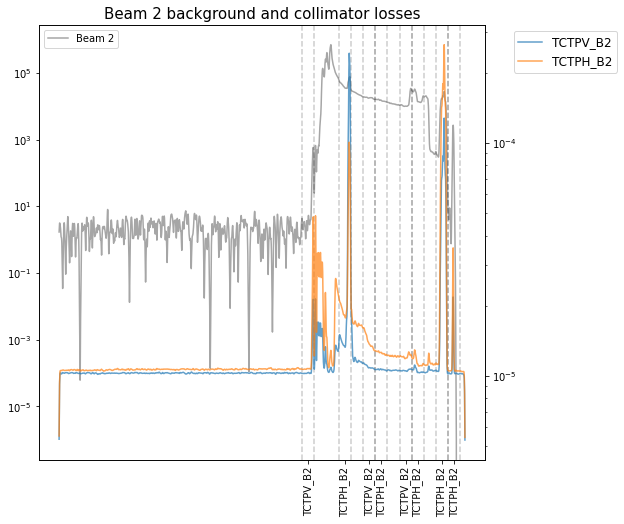

In [6]:


class Segments(Dataset):

    def __init__(self,variables,target,times = None,scale_data = False,log_scale = False):
        
        if scale_data:
            self.target = target
            self.variables = variables
            self.scale()

        self.variables = torch.as_tensor(variables,dtype = torch.float32)
        self.n_variables = self.variables.shape[1]
        self.target = torch.as_tensor(target,dtype = torch.float32)
        self.N = self.target.shape[0]
        self.times = times

    
    
    def __len__(self):
        return self.N

    def __getitem__(self,index):
        return self.variables[index,:],self.target[index],index

    def scale(self):
        
        self.target_scaler = StandardScaler()
        self.variable_scaler = StandardScaler()
        self.target = np.expand_dims(self.target,axis = 1)
        self.target = self.target_scaler.fit_transform(self.target).flatten()
        self.variables = self.variable_scaler.fit_transform(self.variables).flatten()

    @classmethod
    def from_start_to_stop(cls,variables,targets,times,start,stop):
        """
        start,stop: datetimeobjects pareseble to timestamp
        indicates start and stop of the interval we're interested in
        """
        start_stamp = datetime.datetime.timestamp(start)
        stop_stamp = datetime.datetime.timestamp(stop)
        idx = times > start_stamp
        idx = np.logical_and(idx,times < stop_stamp)
        return cls.Segments(variables[idx],targets[idx])



class Interval_Correlator():

    def __init__(self,
    variables,
    targets,
    variable_names,frac = 0.05,times = None,scale_data = False):
        self.variable_names = variable_names
        self.frac = frac
        self.dataset = Segments(variables,targets,times = times,scale_data= scale_data)
        self.loader = DataLoader(
            self.dataset,
            batch_size = int(self.frac*self.dataset.__len__()),
            shuffle = False
            )
            
        self.similarity = nn.CosineSimilarity(dim = 0)

        self.most_dominant = defaultdict(list)
        self.top_variables = dict()
        self.name_idx = {self.variable_names[i]:i for i in range(len(self.variable_names))}
        self.ticks = []
        self.tick_labels = []
    @property
    def times(self):
        return self.dataset.times

    @property
    def target(self):
        return self.dataset.target
    @property
    def variables(self):
        return self.dataset.variables
    @property
    def n_variables(self):
        return self.dataset.n_variables

    def correlate_intervals(self, treshold = 0.9):
        var_scaler = StandardScaler()#MinMaxScaler()
        target_scaler = StandardScaler()#MinMaxScaler()
        with torch.no_grad():
            for x,y,idx in self.loader:
            
                X = x - torch.mean(x,dim = 0)
                Y = y - torch.mean(y,dim = 0)
                sims = torch.zeros(self.n_variables)
                for j in range(self.n_variables):
                    sims[j] +=self.similarity(X[:,j],Y) #torch.tensor(pearsonr(
                        #X[:,j].detach().numpy(),
                        #Y[:].detach().numpy()
                    #)[0])
                
                if torch.max(sims)>treshold:
                    print(torch.max(sims))
                    self.most_dominant[
                    self.variable_names[torch.argmax(sims ).item()]
                    ].append(idx.detach().numpy())
    
    
    def plot_intervals(self,mark_variables = True, beam = 1):
        frame,fig = plt.subplots(figsize = (8,8))
        if self.times is not None:
            X = self.times
        else:
            X = range(self.dataset.__len__())
        Y = torch.max(self.target)
        fig.plot(X,self.dataset.target.detach().numpy(),
        label = f"Beam {beam}",alpha = 0.7,color = "grey",)
        
        for var in self.most_dominant.keys():
            self.mark_variable_intervals(var,fig,X,y = Y,mark_variables = mark_variables)
        
        if len(self.ticks) !=0:
            fig.set_xticks(self.ticks)
            fig.set_xticklabels(self.tick_labels,rotation = 90)
        
        return fig


    def mark_variable_intervals(self,variable,fig,X,y = 1,mark_variables = True):
        intervals = self.most_dominant[variable]
        if len(intervals) == 0:
            return
        N = X[-1]
        if mark_variables:
            for inter in intervals:
                if len(inter)/self.dataset.__len__()<0:
                    continue
                i1 = np.min(inter)
                i2 = np.max(inter)
                fig.axvline(X[i1],linestyle = "--",color = "k",alpha = 0.2)
                fig.axvline(X[i2],linestyle = "--",color = "k",alpha = 0.2)
                i = int(0.5*(i1+i2))
                self.ticks.append(X[i])
                self.tick_labels.append(variable)
                
        self.top_variables[variable] = self.name_idx[variable]


start = 16_000
convfrac = 0.01
N = len(aug.times[start:])
y = aug.gaussian_conv(aug.minusz[start:],frac = convfrac)
#y = aug.minusz[start:]
x = list()
losses = ["TCTPH_B1", "TCTPH_B2", "TCTPV_B1", "TCTPV_B2"]#aug.loss_variables
variable_dict = {var:i for i,var in enumerate(losses+aug.vacuum_variables )}#+ collimator_columns)}#aug.vacuum_variables )}#}
for var in losses+aug.vacuum_variables:#+ collimator_columns: #+ aug.vacuum_variables:#
    if var not in collimator_columns:
        x.append(
            aug.gaussian_conv(aug.all_data[var].values[start:],frac = convfrac)
            )
    else:
        x.append(aug.all_data[var].values[start:])

x = np.array(x).T
correlator = Interval_Correlator(
    x,y,
    list(variable_dict.keys()),
    times = aug.times[start:], frac = 0.03,scale_data = False)

correlator.correlate_intervals(treshold = 0.75)

fig = correlator.plot_intervals(mark_variables = True,beam = 2)
fig.legend()
#fig.set_ylim(1e-1,1e7)
fig.set_yscale("log")
tw = fig.twinx()
for k,v in correlator.top_variables.items():
    tw.plot(correlator.times, correlator.variables[:,v],label = k,alpha = 0.7)
#tw.set_ylim(7e-8,5e-3)
tw.legend(bbox_to_anchor = (1.05,1),fontsize = 12,loc = "upper left")
tw.set_yscale("log")
#fig.set_xlim(40000+ 1.6558e9,47000 + 1.6558e9)
#fig.set_xlim(aug.times[-3000],aug.times[-1])
fig.set_title("Beam 2 background and collimator losses",fontsize = 15)

In [7]:
convfrac = 0.02
y = aug.gaussian_conv(aug.plusz[start:],frac = convfrac)

x = np.array(x).T

x = list()
losses = ["TCTPH_B1", "TCTPH_B2", "TCTPV_B1", "TCTPV_B2"]#aug.loss_variables
variable_dict = {var:i for i,var in enumerate(losses +aug.vacuum_variables )}#+ collimator_columns)}#aug.vacuum_variables )}#}
for var in losses+ aug.vacuum_variables:#+ collimator_columns: ##
    if var not in collimator_columns:
        x.append(
            aug.gaussian_conv(aug.all_data[var].values[start:],frac = convfrac)
            )
    else:
        x.append(aug.all_data[var].values[start:])

x = np.array(x).T
correlator = Interval_Correlator(
    x,y,
    list(variable_dict.keys()),
    times = aug.times[start:], frac = 0.08,scale_data = False)

correlator.correlate_intervals(spikes = False,treshold = 0.75)

fig = correlator.plot_intervals(mark_variables = True,beam = 2)
fig.legend()
#fig.set_ylim(1e-1,1e7)
fig.set_yscale("log")
tw = fig.twinx()
for k,v in correlator.top_variables.items():
    tw.plot(correlator.times, correlator.variables[:,v],label = k,alpha = 0.7)
#tw.set_ylim(7e-8,5e-3)
tw.legend(bbox_to_anchor = (1.05,1),fontsize = 12,loc = "upper left")
tw.set_yscale("log")
#fig.set_xlim(40000+ 1.6558e9,47000 + 1.6558e9)
#fig.set_xlim(aug.times[-3000],aug.times[-1])
fig.set_title("Beam 1 background and collimator losses",fontsize = 15)

TypeError: Interval_Correlator.correlate_intervals() got an unexpected keyword argument 'spikes'

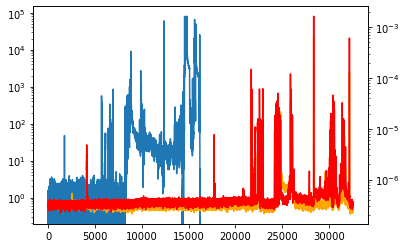

In [ ]:
plt.plot(aug.plusz[start:])

plt.yscale("log")

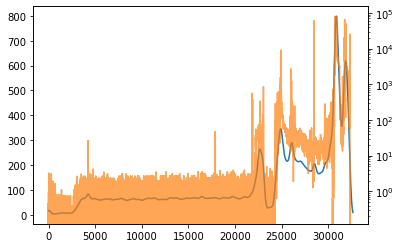

In [ ]:
y = aug.gaussian_conv(np.log(np.fabs(np.diff(bkg.plusz))+1),frac = 0.05)

plt.plot(
    y
    )
plt.twinx()
plt.plot(bkg.plusz,color = "tab:orange",alpha = 0.7)
plt.yscale("log")

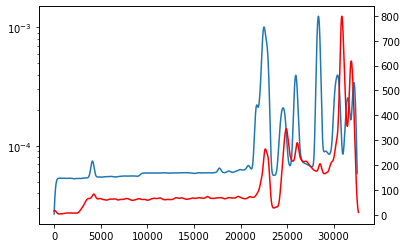

In [ ]:
lv = aug.loss_variables[0]
plt.plot(aug.gaussian_conv(aug.all_data[lv].values,frac = 0.05))
plt.yscale("log")
plt.twinx()
plt.plot(y,color = "red")